# 1.-Intalacion de librerias

In [ ]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2.-LIMPIAR IMAGENES DE RUTA DESCONOCIDA

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'dataset-resized' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3.-CARGAR DATOS

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('dataset-resized')

Found 2527 files belonging to 6 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

In [12]:
len(batch)

2

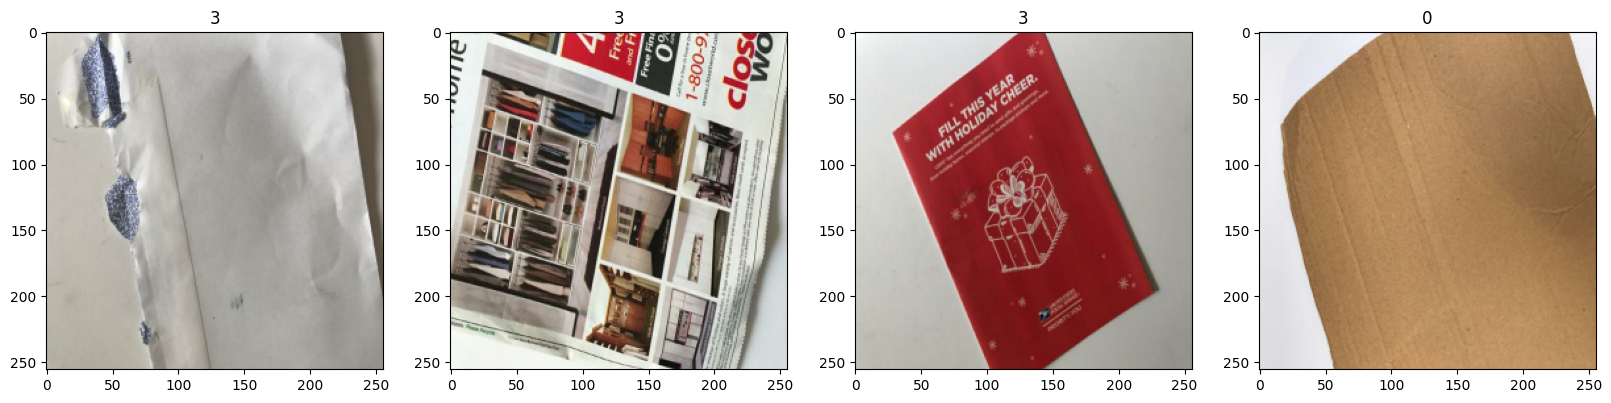

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4.- ESCALAR DATOS

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[1.        , 0.8568627 , 0.85294116],
          [1.        , 0.85490197, 0.8509804 ],
          [1.        , 0.8509804 , 0.84705883],
          ...,
          [0.49411765, 0.4392157 , 0.4357843 ],
          [0.48235294, 0.42843136, 0.42843136],
          [0.45882353, 0.4117647 , 0.4117647 ]],
 
         [[1.        , 0.8568627 , 0.85294116],
          [1.        , 0.85490197, 0.8509804 ],
          [1.        , 0.8509804 , 0.84705883],
          ...,
          [0.47941175, 0.42745098, 0.42990196],
          [0.47205883, 0.4269608 , 0.43137255],
          [0.45588234, 0.41470587, 0.41764706]],
 
         [[1.        , 0.8568627 , 0.85294116],
          [1.        , 0.85490197, 0.8509804 ],
          [1.        , 0.8509804 , 0.84705883],
          ...,
          [0.4622549 , 0.41911766, 0.42745098],
          [0.46372548, 0.42303923, 0.43480393],
          [0.4504902 , 0.40931374, 0.4259804 ]],
 
         ...,
 
         [[0.72745097, 0.80196077, 0.8568627 ],
          [0.72549

# 5.-SEPARAR DATOS

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

55

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6.-CONSTRUCCION DEL DEEP LEARNING

In [50]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [52]:
model = Sequential()

In [53]:
altura_imagen = 128
ancho_imagen = 128
canales_imagen = 3

In [ ]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(altura_imagen, ancho_imagen, canales_imagen)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplana los datos para pasarlos a una capa densa
model.add(Flatten())

# Capas densas y de salida
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

# Compila el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 7.-ENTREANAMIENTO

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

# 8.-RENDIMIENTO 

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9.-EVALUAR

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

# 10.-TESTEO

In [ ]:
import cv2